In [25]:
#library import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib notebook
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk.metrics import ConfusionMatrix
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import flatten
from nltk import FreqDist
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
test_df = pd.read_csv('test.tsv', sep='\t') #importing the test frame
train_df = pd.read_csv('train.tsv', sep = '\t') #importing the train frame

In [3]:
train_df.head(10) #looking at the first 10 rows of the training dataset

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [4]:
train_df.info() #glancing throguh the info about the fram like the columns, their data types etc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [5]:
train_df['Sentiment'].value_counts() #now as we have to predict the sentiment value, giving a good look at the count of each of the sentiment

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

No handles with labels found to put in legend.


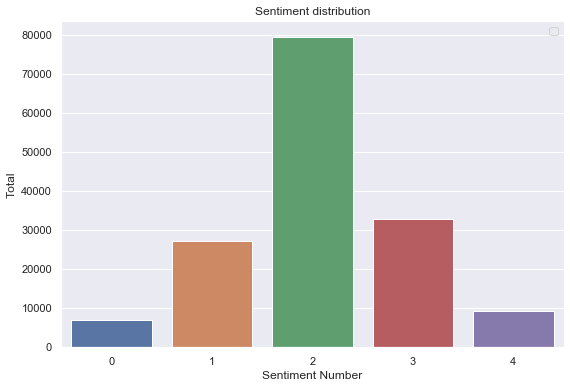

In [6]:
#lets look at the distribution of the sentiment over the train data
plt.figure(figsize = [9,6])
sns.countplot(x="Sentiment", data=train_df)
plt.title('Sentiment distribution')
plt.ylabel('Total')
plt.xlabel('Sentiment Number')
plt.legend()
plt.show();

In [7]:
test_df.head(10) #repeating the above proess with the test dataset

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [79]:
stopwords = nltk.corpus.stopwords.words('english') #defining the stopwords variable 
newstopwords = [word for word in stopwords if word not in ['not', 'no', 'can','don', 't','n']] #adding a few more that werent there

In [73]:
#the below created function is used to pre process the data especially focusing on the phrase column of the frame
def sentence_cleaning(df):
    sentence = []
    for sent in tqdm(df['Phrase']):
        text = re.sub("[^a-zA-Z]"," ",sent.lower())
        word = word_tokenize(text.lower())
        new_words = [ ele for ele in word if ele.lower() not in newstopwords ]
        lemmatizer = WordNetLemmatizer()
        lemm_word = [lemmatizer.lemmatize(i) for i in new_words]
        sentence.append(lemm_word)
    return (sentence)

In [11]:
train_sentence = sentence_cleaning(train_df) #creating a different list by running the function

100%|██████████| 156060/156060 [00:29<00:00, 5309.88it/s]


In [12]:
train_df['Phrase'] = sentence_cleaning(train_df) #now just also applying it on the column inside the frame

100%|██████████| 156060/156060 [00:25<00:00, 6062.52it/s]


In [13]:
train_df_copy = train_df #copying the train_df frame into another frame so that we dont mess up with the orignal frame
train_df_copy

In [80]:
#top 200 most repeated words in the list
flattened_list = flatten(train_sentence)
def repeated_topwords(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = [w for (w, c) in wordlist.most_common(200)] 
    return word_features 

In [81]:
#applying the feature and printing it
features = repeated_topwords(flattened_list)
print(features)

['film', 'movie', 't', 'n', 'one', 'not', 'like', 'character', 'story', 'time', 'rrb', 'make', 'good', 'lrb', 'life', 'comedy', 'no', 'much', 'way', 'can', 'work', 'even', 'little', 'funny', 'well', 'performance', 'director', 'love', 'year', 'feel', 'new', 'bad', 'u', 'enough', 'get', 'action', 'thing', 'made', 'old', 'audience', 'two', 'something', 'minute', 'would', 'best', 'look', 'never', 'many', 'people', 'come', 'see', 'self', 'plot', 'drama', 'world', 'take', 'first', 'may', 'could', 'better', 'long', 'go', 'big', 'sense', 'really', 'man', 'give', 'moment', 'actor', 'without', 'real', 'great', 'screen', 'every', 'humor', 'end', 'ever', 'family', 'scene', 'another', 'woman', 'american', 'heart', 'picture', 'cast', 'hollywood', 'human', 'still', 'hour', 'fun', 'le', 'nothing', 'hard', 'kid', 'kind', 'script', 'often', 'might', 'show', 'far', 'find', 'star', 'lot', 'war', 'acting', 'laugh', 'also', 'seen', 'thriller', 'back', 'interesting', 'original', 'day', 'rather', 'idea', 'wat

In [17]:
#creating unigram
def unigram_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [18]:
#printing the unigram
unigrams = unigram_features(flattened_list,features)
print(unigrams)

{'contains(film)': True, 'contains(movie)': True, 'contains(t)': True, 'contains(n)': True, 'contains(one)': True, 'contains(not)': True, 'contains(like)': True, 'contains(character)': True, 'contains(story)': True, 'contains(time)': True, 'contains(rrb)': True, 'contains(make)': True, 'contains(good)': True, 'contains(lrb)': True, 'contains(life)': True, 'contains(comedy)': True, 'contains(no)': True, 'contains(much)': True, 'contains(way)': True, 'contains(can)': True, 'contains(work)': True, 'contains(even)': True, 'contains(little)': True, 'contains(funny)': True, 'contains(well)': True, 'contains(performance)': True, 'contains(director)': True, 'contains(love)': True, 'contains(year)': True, 'contains(feel)': True, 'contains(new)': True, 'contains(bad)': True, 'contains(u)': True, 'contains(enough)': True, 'contains(get)': True, 'contains(action)': True, 'contains(thing)': True, 'contains(made)': True, 'contains(old)': True, 'contains(audience)': True, 'contains(two)': True, 'cont

In [19]:
#part of speech classifcation
def POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features

In [20]:
#running the above created function and printing the output
POS = POS_features(flattened_list,features)
POS

{'nouns': 297190, 'verbs': 103255, 'adjectives': 154896, 'adverbs': 54015}

In [21]:
#just for the classification task we are just taking only 2 columns fro the main frame
classdataframe = train_df_copy[['Phrase','Sentiment']]
classdataframe

In [23]:
#what this loop does is that it removes all of the square brackets and commas from each of the phrase line
for i in tqdm(range(len(classdataframe))):
    classdataframe['Phrase'][i] = (" ").join(train_df_copy['Phrase'][i])

,Phrase,Sentiment
0,"[series, escapade, demonstrating, adage, good,...",1
1,"[series, escapade, demonstrating, adage, good,...",2
2,[series],2
3,[],2
4,[series],2
...,...,...
156055,[hearst],2
156056,"[forced, avuncular, chortle]",1
156057,"[avuncular, chortle]",3
156058,[avuncular],2


In [58]:
#we are justing trying to seperate the x and the y variable and giving them better names
phrase = classdataframe['Phrase']
sentiment = classdataframe['Sentiment']
phrase.head()

0    s e r i e s   e s c a p a d e   d e m o n s t ...
1       series escapade demonstrating adage good goose
2                                               series
3                                                     
4                                               series
Name: Phrase, dtype: object

In [59]:
#train and validation split, not using test here because we have a different dataframe for test
X_train,X_val,y_train,y_val = train_test_split(\
    phrase,sentiment,test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)

In [65]:
vectorizer = TfidfVectorizer()
tfidf_text = vectorizer.fit_transform(X_train)
#--Training the classifier with  Naive Bayes--
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train,y_train)
test_predict = nb.predict(X_val)
train_accuracy = round(nb.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict, y_val)*100)
print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, y_val))

Naive Bayes Train Accuracy Score : 63.0% 
Naive Bayes Test Accuracy Score  : 58.0% 

              precision    recall  f1-score   support

           0       0.04      0.63      0.08       137
           1       0.25      0.52      0.34      4000
           2       0.89      0.60      0.72     35365
           3       0.38      0.52      0.44      7114
           4       0.04      0.61      0.08       202

    accuracy                           0.58     46818
   macro avg       0.32      0.58      0.33     46818
weighted avg       0.76      0.58      0.64     46818



In [67]:
sgd = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', SGDClassifier()),
               ])
#--Training the classifier with  SVM--
sgd.fit(X_train, y_train)
test_predict = sgd.predict(X_val)
train_accuracy = round(sgd.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict, y_val)*100)
print("SVM Train Accuracy Score : {}% ".format(train_accuracy ))
print("SVM Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, y_val))

SVM Train Accuracy Score : 57.0% 
SVM Test Accuracy Score  : 56.0% 

              precision    recall  f1-score   support

           0       0.07      0.53      0.13       293
           1       0.09      0.49      0.15      1486
           2       0.96      0.56      0.71     40700
           3       0.20      0.52      0.29      3773
           4       0.11      0.56      0.19       566

    accuracy                           0.56     46818
   macro avg       0.29      0.53      0.29     46818
weighted avg       0.86      0.56      0.65     46818



In [68]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])
#--Training the classifier with  Decision tree--
dt.fit(X_train, y_train)
test_predict = dt.predict(X_val)
train_accuracy = round(dt.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict, y_val)*100)
print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, y_val))

Decision Tree Train Accuracy Score : 88.0% 
Decision Tree Test Accuracy Score  : 61.0% 

              precision    recall  f1-score   support

           0       0.42      0.40      0.41      2224
           1       0.49      0.48      0.49      8319
           2       0.75      0.72      0.73     25138
           3       0.48      0.53      0.50      9054
           4       0.36      0.47      0.41      2083

    accuracy                           0.61     46818
   macro avg       0.50      0.52      0.51     46818
weighted avg       0.62      0.61      0.62     46818



In [74]:
#preprocessing the test dataframe
test_df['Phrase'] = sentence_cleaning(test_df)
for i in tqdm(range(len(test_df))):
    test_df['Phrase'][i] = (" ").join(train_df_copy['Phrase'][i])

100%|██████████| 66292/66292 [00:10<00:00, 6481.88it/s]


  0%|          | 0/66292 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 66292/66292 [03:34<00:00, 309.28it/s]


In [76]:
#applying the decision tree predict on it, because we have the highest predicting accuracy
test_id = test_df['PhraseId']
test_text = test_df['Phrase']
y_prdict = dt.predict(test_text)

In [77]:
#creating the submission frame that we have to submit
submission = pd.DataFrame(list(zip(test_id, y_prdict)),
               columns =['PhraseId', 'Sentiment'])
submission.head(20)

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
5,156066,2
6,156067,2
7,156068,2
8,156069,2
9,156070,2


In [78]:
#exporting the frame
submission.to_csv('submission.csv', index=False)